**Корректность проверена на Python 3.6:**
+ pandas 0.23.4
+ numpy 1.15.4
+ matplotlib 3.0.2
+ seaborn 0.9.0

# Линейная регрессия и основные библиотеки Python для анализа данных и научных вычислений

Это задание посвящено линейной регрессии. На примере прогнозирования роста человека по его весу Вы увидите, какая математика за этим стоит, а заодно познакомитесь с основными библиотеками Python, необходимыми для дальнейшего прохождения курса.

**Материалы**

- Лекции данного курса по линейным моделям и градиентному спуску
- [Документация](http://docs.scipy.org/doc/) по библиотекам NumPy и SciPy
- [Документация](http://matplotlib.org/) по библиотеке Matplotlib 
- [Документация](http://pandas.pydata.org/pandas-docs/stable/tutorials.html) по библиотеке Pandas
- [Pandas Cheat Sheet](http://www.analyticsvidhya.com/blog/2015/07/11-steps-perform-data-analysis-pandas-python/)
- [Документация](http://stanford.edu/~mwaskom/software/seaborn/) по библиотеке Seaborn 

## Задание 1. Первичный анализ данных c Pandas

В этом заданиии мы будем использовать данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

**[1].** Если у Вас не установлена библиотека Seaborn - выполните в терминале команду *conda install seaborn*. (Seaborn не входит в сборку Anaconda, но эта библиотека предоставляет удобную высокоуровневую функциональность для визуализации данных).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
%matplotlib inline

Считаем данные по росту и весу (*weights_heights.csv*, приложенный в задании) в объект Pandas DataFrame:

In [21]:
data = pd.read_csv('/Users/alexeyzuev/downloads/weights_heights.csv', index_col='Index')

Чаще всего первое, что надо надо сделать после считывания данных - это посмотреть на первые несколько записей. Так можно отловить ошибки чтения данных (например, если вместо 10 столбцов получился один, в названии которого 9 точек с запятой). Также это позволяет познакомиться с данными, как минимум, посмотреть на признаки и их природу (количественный, категориальный и т.д.). 

После этого стоит построить гистограммы распределения признаков - это опять-таки позволяет понять природу признака (степенное у него распределение, или нормальное, или какое-то еще). Также благодаря гистограмме можно найти какие-то значения, сильно не похожие на другие - "выбросы" в данных. 
Гистограммы удобно строить методом *plot* Pandas DataFrame с аргументом *kind='hist'*.

**Пример.** Построим гистограмму распределения роста подростков из выборки *data*. Используем метод *plot* для DataFrame *data* c аргументами *y='Height'* (это тот признак, распределение которого мы строим)

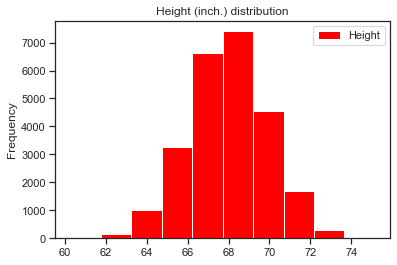

In [22]:
data.plot(y='Height', kind='hist', 
           color='red',  title='Height (inch.) distribution')

Аргументы:

- *y='Height'* - тот признак, распределение которого мы строим
- *kind='hist'* - означает, что строится гистограмма
- *color='red'* - цвет

**[2]**. Посмотрите на первые 5 записей с помощью метода *head* Pandas DataFrame. Нарисуйте гистограмму распределения веса с помощью метода *plot* Pandas DataFrame. Сделайте гистограмму зеленой, подпишите картинку.

In [4]:
data.head(5)

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


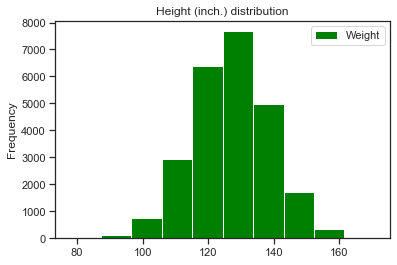

In [23]:
data.plot(y='Weight', kind='hist', 
           color='green',  title='Height (inch.) distribution')

Один из эффективных методов первичного анализа данных - отображение попарных зависимостей признаков. Создается $m \times m$ графиков (*m* - число признаков), где по диагонали рисуются гистограммы распределения признаков, а вне диагонали - scatter plots зависимости двух признаков. Это можно делать с помощью метода $scatter\_matrix$ Pandas Data Frame или *pairplot* библиотеки Seaborn. 

Чтобы проиллюстрировать этот метод, интересней добавить третий признак. Создадим признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index)). Для этого воспользуемся удобной связкой метода *apply* Pandas DataFrame и lambda-функций Python.

In [24]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [25]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)

**[3].** Постройте картинку, на которой будут отображены попарные зависимости признаков , 'Height', 'Weight' и 'BMI' друг от друга. Используйте метод *pairplot* библиотеки Seaborn.

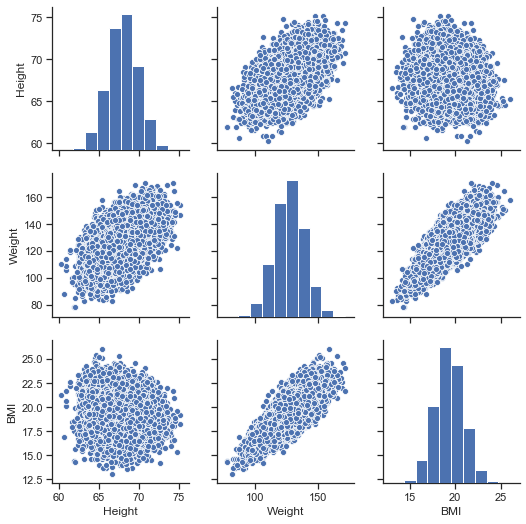

In [26]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data)

Часто при первичном анализе данных надо исследовать зависимость какого-то количественного признака от категориального (скажем, зарплаты от пола сотрудника). В этом помогут "ящики с усами" - boxplots библиотеки Seaborn. Box plot - это компактный способ показать статистики вещественного признака (среднее и квартили) по разным значениям категориального признака. Также помогает отслеживать "выбросы" - наблюдения, в которых значение данного вещественного признака сильно отличается от других. 

**[4]**. Создайте в DataFrame *data* новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. Постройте «ящик с усами» (boxplot), демонстрирующий зависимость роста от весовой категории. Используйте метод *boxplot* библиотеки Seaborn и метод *apply* Pandas DataFrame. Подпишите ось *y* меткой «Рост», ось *x* – меткой «Весовая категория».

[Text(0, 0.5, 'Рост'),
 Text(0.5, 0, 'Весовая категория'),
 Text(0.5, 1.0, 'Зависимость роста от весовой категории')]

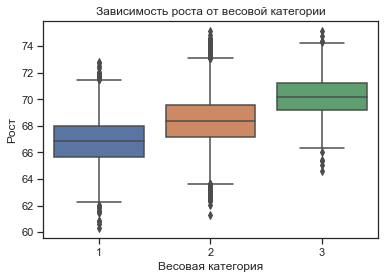

In [33]:
def weight_category(weight):
    if weight < 120: return 1
    if weight >= 150: return 3
    return 2

data['weight_cat'] = data['Weight'].apply(weight_category)

sns.boxplot(x=data['weight_cat'], y=data['Height']).set(
    xlabel='Весовая категория', 
    ylabel='Рост', title = 'Зависимость роста от весовой категории')

**[5].** Постройте scatter plot зависимости роста от веса, используя метод *plot* для Pandas DataFrame с аргументом *kind='scatter'*. Подпишите картинку.

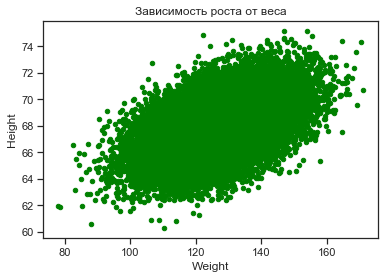

In [31]:
data.plot(kind='scatter', x = 'Weight', y = 'Height', c='Green', title = 'Зависимость роста от веса')

## Задание 2. Минимизация квадратичной ошибки

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки. 

**[6].** Напишите функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [34]:
def sq_error(w0,w1): 
    return np.sum((data['Height'] - (w0+w1 * data['Weight'])) ** 2)

Итак, мы решаем задачу: как через облако точек, соответсвующих наблюдениям в нашем наборе данных, в пространстве признаков "Рост" и "Вес" провести прямую линию так, чтобы минимизировать функционал из п. 6. Для начала давайте отобразим хоть какие-то прямые и убедимся, что они плохо передают зависимость роста от веса.

**[7].** Проведите на графике из п. 5 Задания 1 две прямые, соответствующие значениям параметров ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$. Используйте метод *plot* из *matplotlib.pyplot*, а также метод *linspace* библиотеки NumPy. Подпишите оси и график.

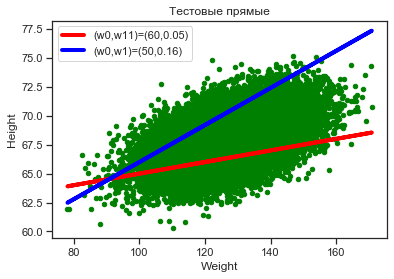

In [49]:
data.plot(kind='scatter', x = 'Weight', y = 'Height', c='Green')
plt.plot(data['Weight'], data['Weight'] * 0.05 + 60, color = 'Red', linewidth=4.0, label ='(w0,w11)=(60,0.05)')
plt.plot(data['Weight'], data['Weight'] * 0.16 + 50, color = 'Blue',linewidth=4.0, label ='(w0,w1)=(50,0.16)')
plt.title('Тестовые прямые')
plt.legend()

Минимизация квадратичной функции ошибки - относительная простая задача, поскольку функция выпуклая. Для такой задачи существует много методов оптимизации. Посмотрим, как функция ошибки зависит от одного параметра (наклон прямой), если второй параметр (свободный член) зафиксировать.

**[8].** Постройте график зависимости функции ошибки, посчитанной в п. 6, от параметра $w_1$ при $w_0$ = 50. Подпишите оси и график.

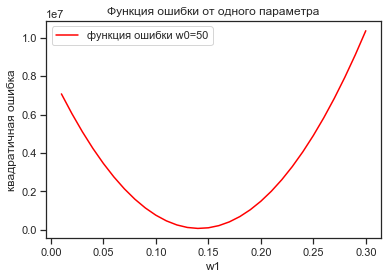

In [50]:
w1 = np.linspace(0.01, 0.3, 30)
w0 = 50
y = [sq_error(w0, w_1) for w_1 in w1]
plt.plot(w1, y , color = 'Red', label ='функция ошибки w0=50')
plt.xlabel('w1')
plt.ylabel('квадратичная ошибка')
plt.title('Функция ошибки от одного параметра')
plt.legend()

Теперь методом оптимизации найдем "оптимальный" наклон прямой, приближающей зависимость роста от веса, при фиксированном коэффициенте $w_0 = 50$.

**[9].** С помощью метода *minimize_scalar* из *scipy.optimize* найдите минимум функции, определенной в п. 6, для значений параметра  $w_1$ в диапазоне [-5,5]. Проведите на графике из п. 5 Задания 1 прямую, соответствующую значениям параметров ($w_0$, $w_1$) = (50, $w_1\_opt$), где $w_1\_opt$ – найденное в п. 8 оптимальное значение параметра $w_1$. 

In [14]:
w0 = 50
min_w1 = minimize_scalar(lambda w1: sq_error(50, w1), bounds=[-5, 5], method='bounded')
min_w1.x

0.14109203728834374

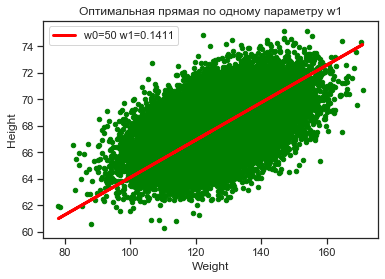

In [51]:
data.plot(kind='scatter', x = 'Weight', y = 'Height', c='Green')
plt.plot(data['Weight'], data['Weight'] * min_w1.x + w0, color = 'Red', 
         linewidth=3, label = 'w0={} w1={}'.format(w0, round(min_w1.x,4)))
plt.title('Оптимальная прямая по одному параметру w1')
plt.legend()

При анализе многомерных данных человек часто хочет получить интуитивное представление о природе данных с помощью визуализации. Увы, при числе признаков больше 3 такие картинки нарисовать невозможно. На практике для визуализации данных в 2D и 3D в данных выделаяют 2 или, соответственно, 3 главные компоненты (как именно это делается - мы увидим далее в курсе) и отображают данные на плоскости или в объеме. 

Посмотрим, как в Python рисовать 3D картинки, на примере отображения функции $z(x,y) = sin(\sqrt{x^2+y^2})$ для значений $x$ и $y$ из интервала [-5,5] c шагом 0.25.

In [16]:
from mpl_toolkits.mplot3d import Axes3D

Создаем объекты типа matplotlib.figure.Figure (рисунок) и  matplotlib.axes._subplots.Axes3DSubplot (ось). 

**[10].** Постройте 3D-график зависимости функции ошибки, посчитанной в п.6 от параметров $w_0$ и $w_1$. Подпишите ось $x$ меткой «Intercept», ось $y$ – меткой «Slope», a ось $z$ – меткой «Error».

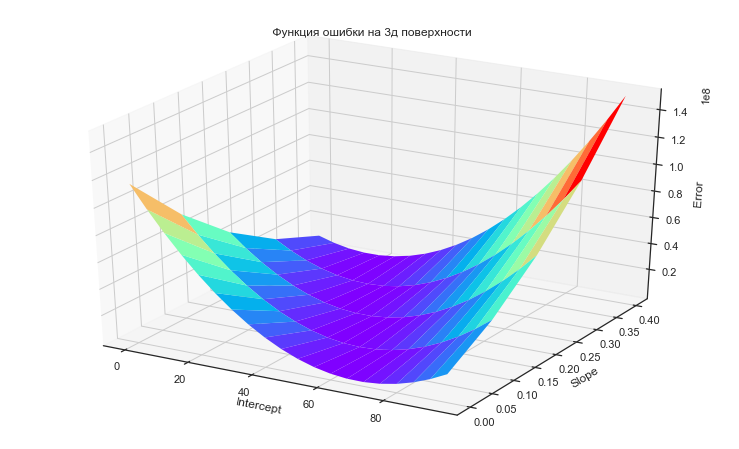

In [47]:
X = np.arange(0, 100, 5)
Y = np.arange(0, 0.5, 0.1)
X, Y = np.meshgrid(X, Y)

verror = np.vectorize(sq_error)

Z = verror(X,Y)

fig = plt.figure(figsize=(13,8))
ax = plt.axes(projection="3d")
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='rainbow', edgecolor='none')
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Error')
ax.set_title(' Функция ошибки на 3д поверхности')
plt.show()

**[11].** С помощью метода *minimize* из scipy.optimize найдите минимум функции, определенной в п. 6, для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5]. Начальная точка – ($w_0$, $w_1$) = (0, 0). Используйте метод оптимизации L-BFGS-B (аргумент method метода minimize). Проведите на графике из п. 5 Задания 1 прямую, соответствующую найденным оптимальным значениям параметров $w_0$ и $w_1$. Подпишите оси и график.

Минимум фукнции ошибки по двум переменным w0, w1 =  [57.57179162  0.08200637]


Text(0.5, 1.0, 'Оптимальная прямая по двум параметрам w0 = 58.0 w1 = 0.08')

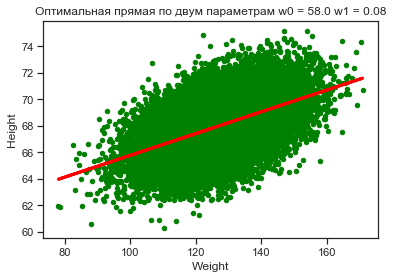

In [59]:
min_2_args = minimize(lambda w: sq_error(*w), x0=(0,0), bounds=((-100,100),(-5,5)), method='L-BFGS-B')
print('Минимум фукнции ошибки по двум переменным w0, w1 = ', min_2_args.x)

data.plot(kind='scatter', x = 'Weight', y = 'Height', c='Green')
plt.plot(data['Weight'], data['Weight'] * min_2_args.x[1] + min_2_args.x[0], color = 'Red', 
         linewidth=3)
plt.title('Оптимальная прямая по двум параметрам w0 = {} w1 = {}'.format(round(min_2_args.x[0]), 
                                                                         round(min_2_args.x[1],2)))


## Критерии оценки работы